In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor

from matplotlib.colors import LogNorm

%matplotlib inline

In [154]:
# 9yr anomaly params
fit = [[0.10, 0.03, 0.28],
       [-12.77, -13.00, -12.54],
       [1.15, 0.82, 1.37],
       [2.81, 2.65, 2.98],
       [55421.59, 55375.30, 55467.40]]

In [297]:
slice_yr = 11.5
rundir = '/home/pbaker/nanograv/bwm/tests/dropout_k/{:.1f}/'.format(slice_yr)

with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]
    
# get just bwm params
par_bwm = params[-5:]
idx_bwm = [params.index(p) for p in par_bwm]
idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

idx_k = []
par_k = []
for par in params:
    if "psrk" in par:
        idx_k.append(params.index(par))
        par_k.append(par)

In [298]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values

In [299]:
burn = int(0.15 * len(chain_raw))
chain = chain_raw[burn:]
chain_bwm = chain[:,idx_bwm]  # no ephem model
chain_L = chain[:,-4]

corr = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corrL = {}".format(N, corr))

N = 161415, corrL = 550.078713465


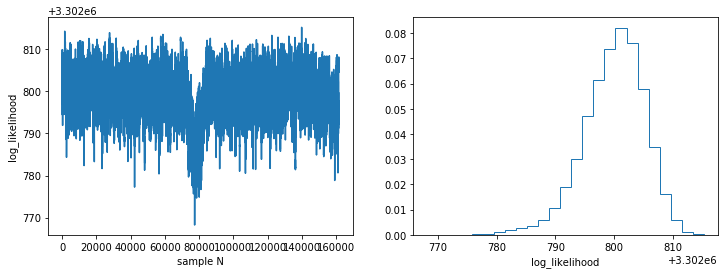

In [300]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.plot(chain_L)
ax1.set_ylabel('log_likelihood')
ax1.set_xlabel('sample N')

ax2 = fig.add_subplot(122)
ax2.hist(chain_L, bins=25, normed=True, histtype='step')
ax2.set_xlabel('log_likelihood')

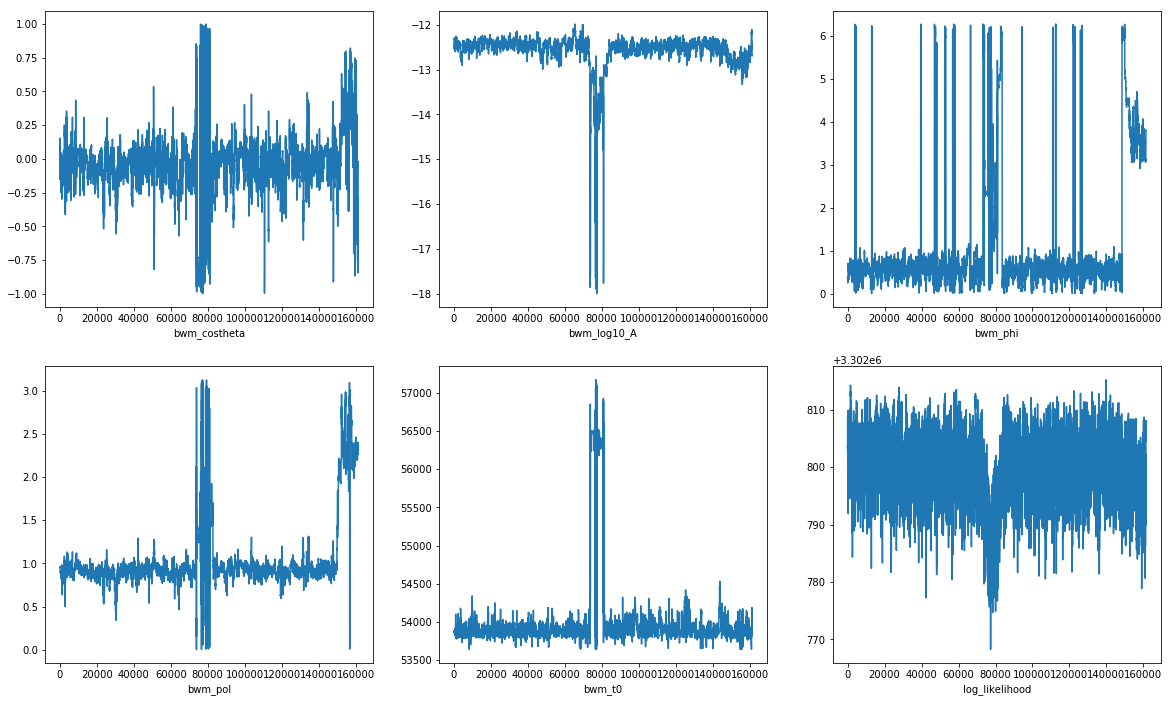

In [301]:
ax = []
fig = plt.figure(figsize=(20,12))

for pp, par in enumerate(par_bwm):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].plot(chain_bwm[:,pp])
    ax[pp].set_xlabel(par)

ax.append(fig.add_subplot(2,3,6))
ax[5].plot(chain[:,-4])
ax[5].set_xlabel('log_likelihood')

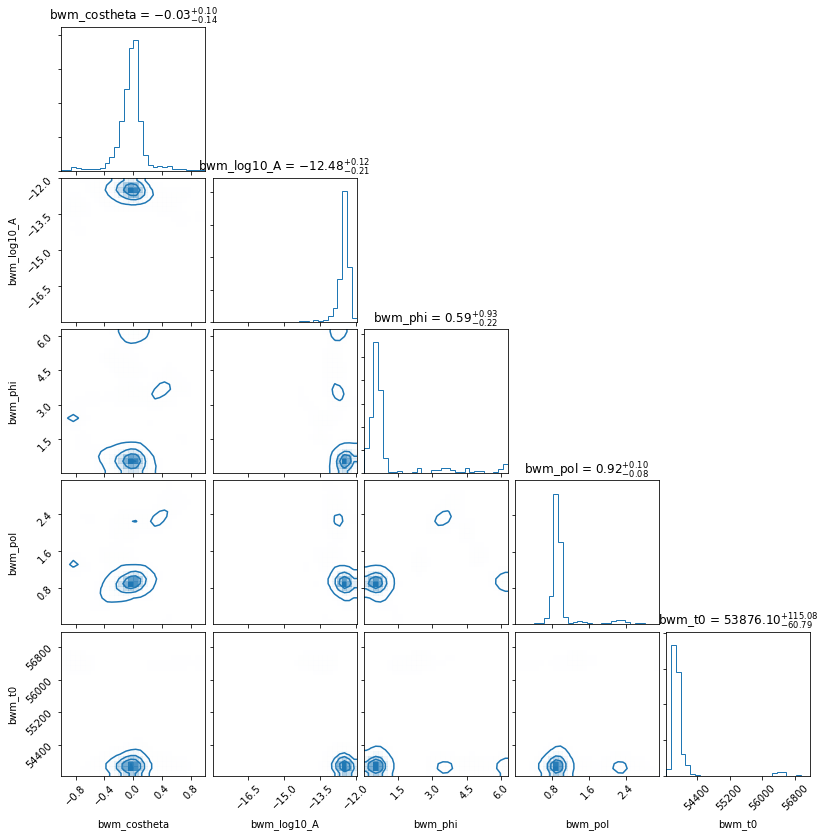

In [302]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':1.0,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);

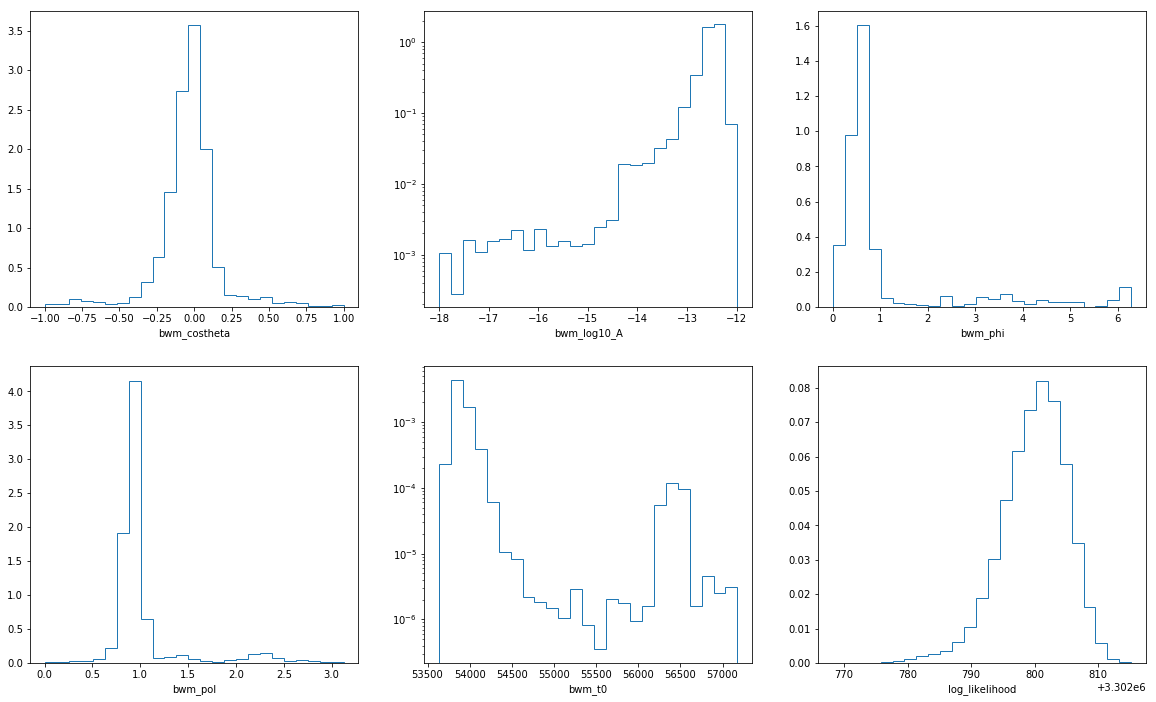

In [303]:
ax = []
fig = plt.figure(figsize=(20,12))

for pp, par in enumerate(par_bwm):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].hist(chain_bwm[:,pp], bins=25, normed=True, histtype='step') #, label='')
    ax[pp].set_xlabel(par)

#ax[0].legend(loc='upper left')
ax[idx_A].set_yscale('log')
ax[idx_t0].set_yscale('log')

ax.append(fig.add_subplot(2,3,6))
ax[5].hist(chain[:,-4], bins=25, normed=True, histtype='step')
ax[5].set_xlabel('log_likelihood')

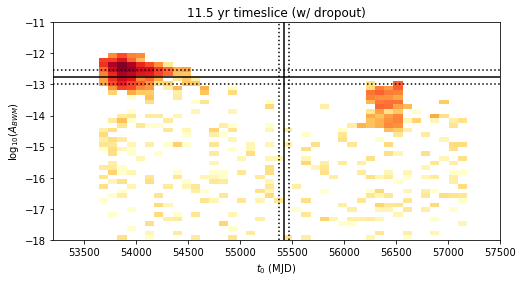

In [304]:
lognorm = LogNorm()

hist_kwargs = {'bins':40,
               'normed':True,
               'cmap':'YlOrRd',
               #'vmin':1.0e5,
               #'vmax':1.0e10,
               'norm':lognorm,
                }

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

t0_ch = chain_bwm[:,idx_t0]
h_ch = chain_bwm[:,idx_A]
    
ax.hist2d(t0_ch, h_ch, **hist_kwargs)

ax.axvline(x=fit[idx_t0][0], color='k')
ax.axvline(x=fit[idx_t0][1], color='k', linestyle=':')
ax.axvline(x=fit[idx_t0][2], color='k', linestyle=':')
ax.axhline(y=fit[idx_A][0], color='k')
ax.axhline(y=fit[idx_A][1], color='k', linestyle=':')
ax.axhline(y=fit[idx_A][2], color='k', linestyle=':')


ax.set_xlabel(r'$t_0$ (MJD)')
ax.set_ylabel(r'$\log_{10}(A_{BWM})$')
ax.set_ylim([-18,-11])
ax.set_xlim([53200, 57500])
ax.set_title('{:.1f} yr timeslice (w/ dropout)'.format(slice_yr))

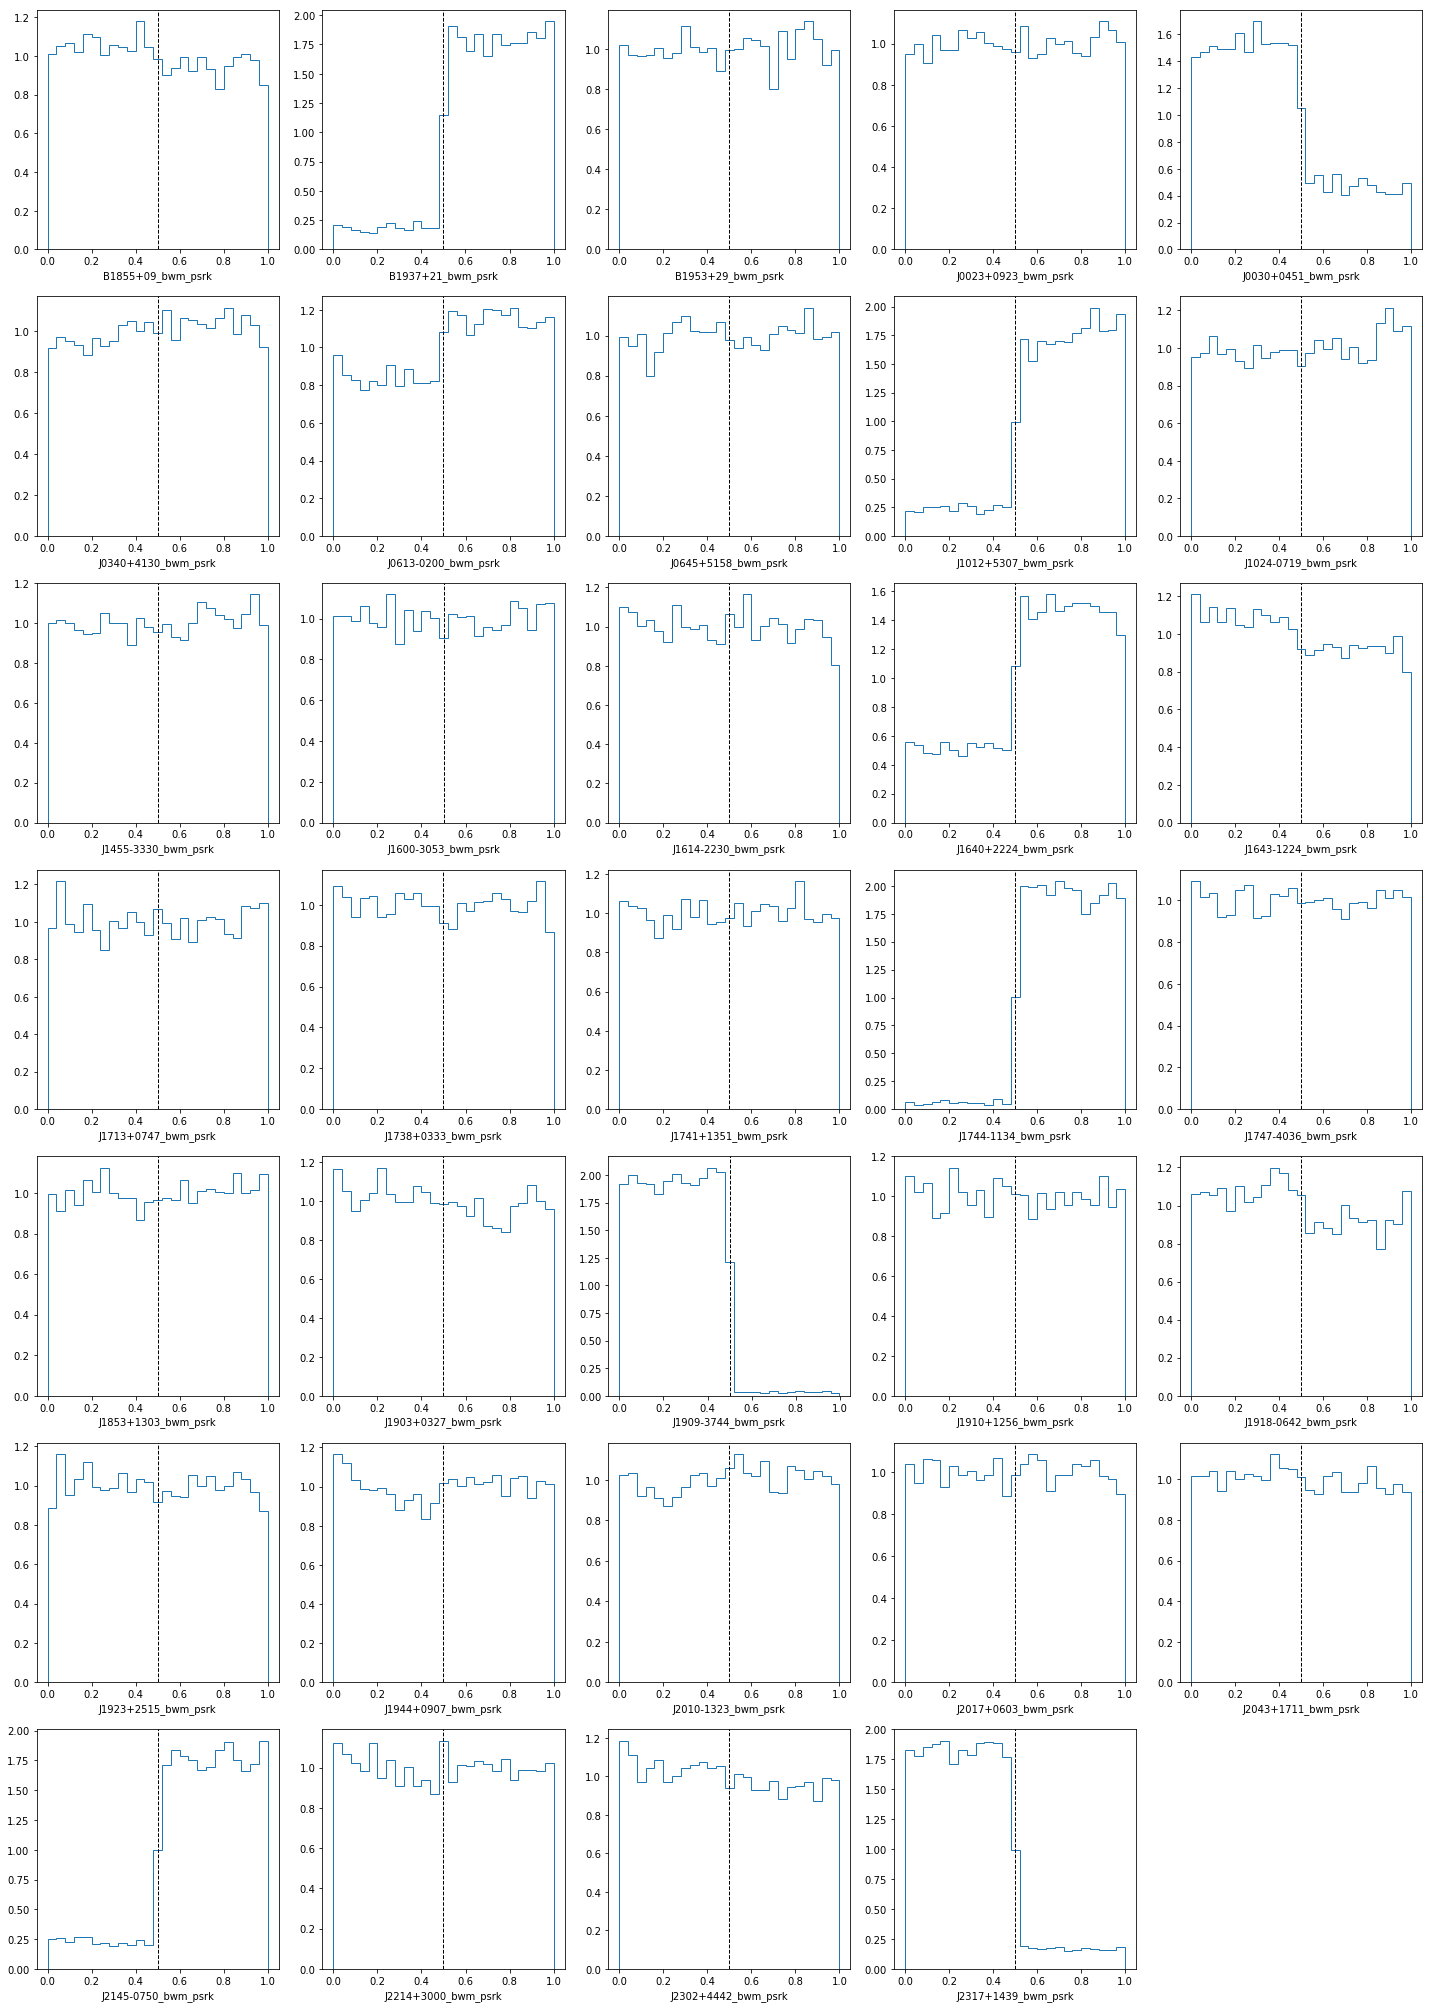

In [305]:
Ncols = 5
Nrows = len(par_k)//Ncols
if Nrows*Ncols < len(par_k):
    Nrows += 1
ax = []
fig = plt.figure(figsize=(20,4*Nrows))

for pp, par in enumerate(par_k):
    ax.append(fig.add_subplot(Nrows,Ncols,pp+1))
    ax[pp].hist(chain[:,idx_k[pp]], bins=25, normed=True, histtype='step') #, label='')
    ax[pp].axvline(x=0.5, color='k', ls='--', lw=1)
    ax[pp].set_xlabel(par)
    #ax[pp].set_yscale('log')
plt.tight_layout()

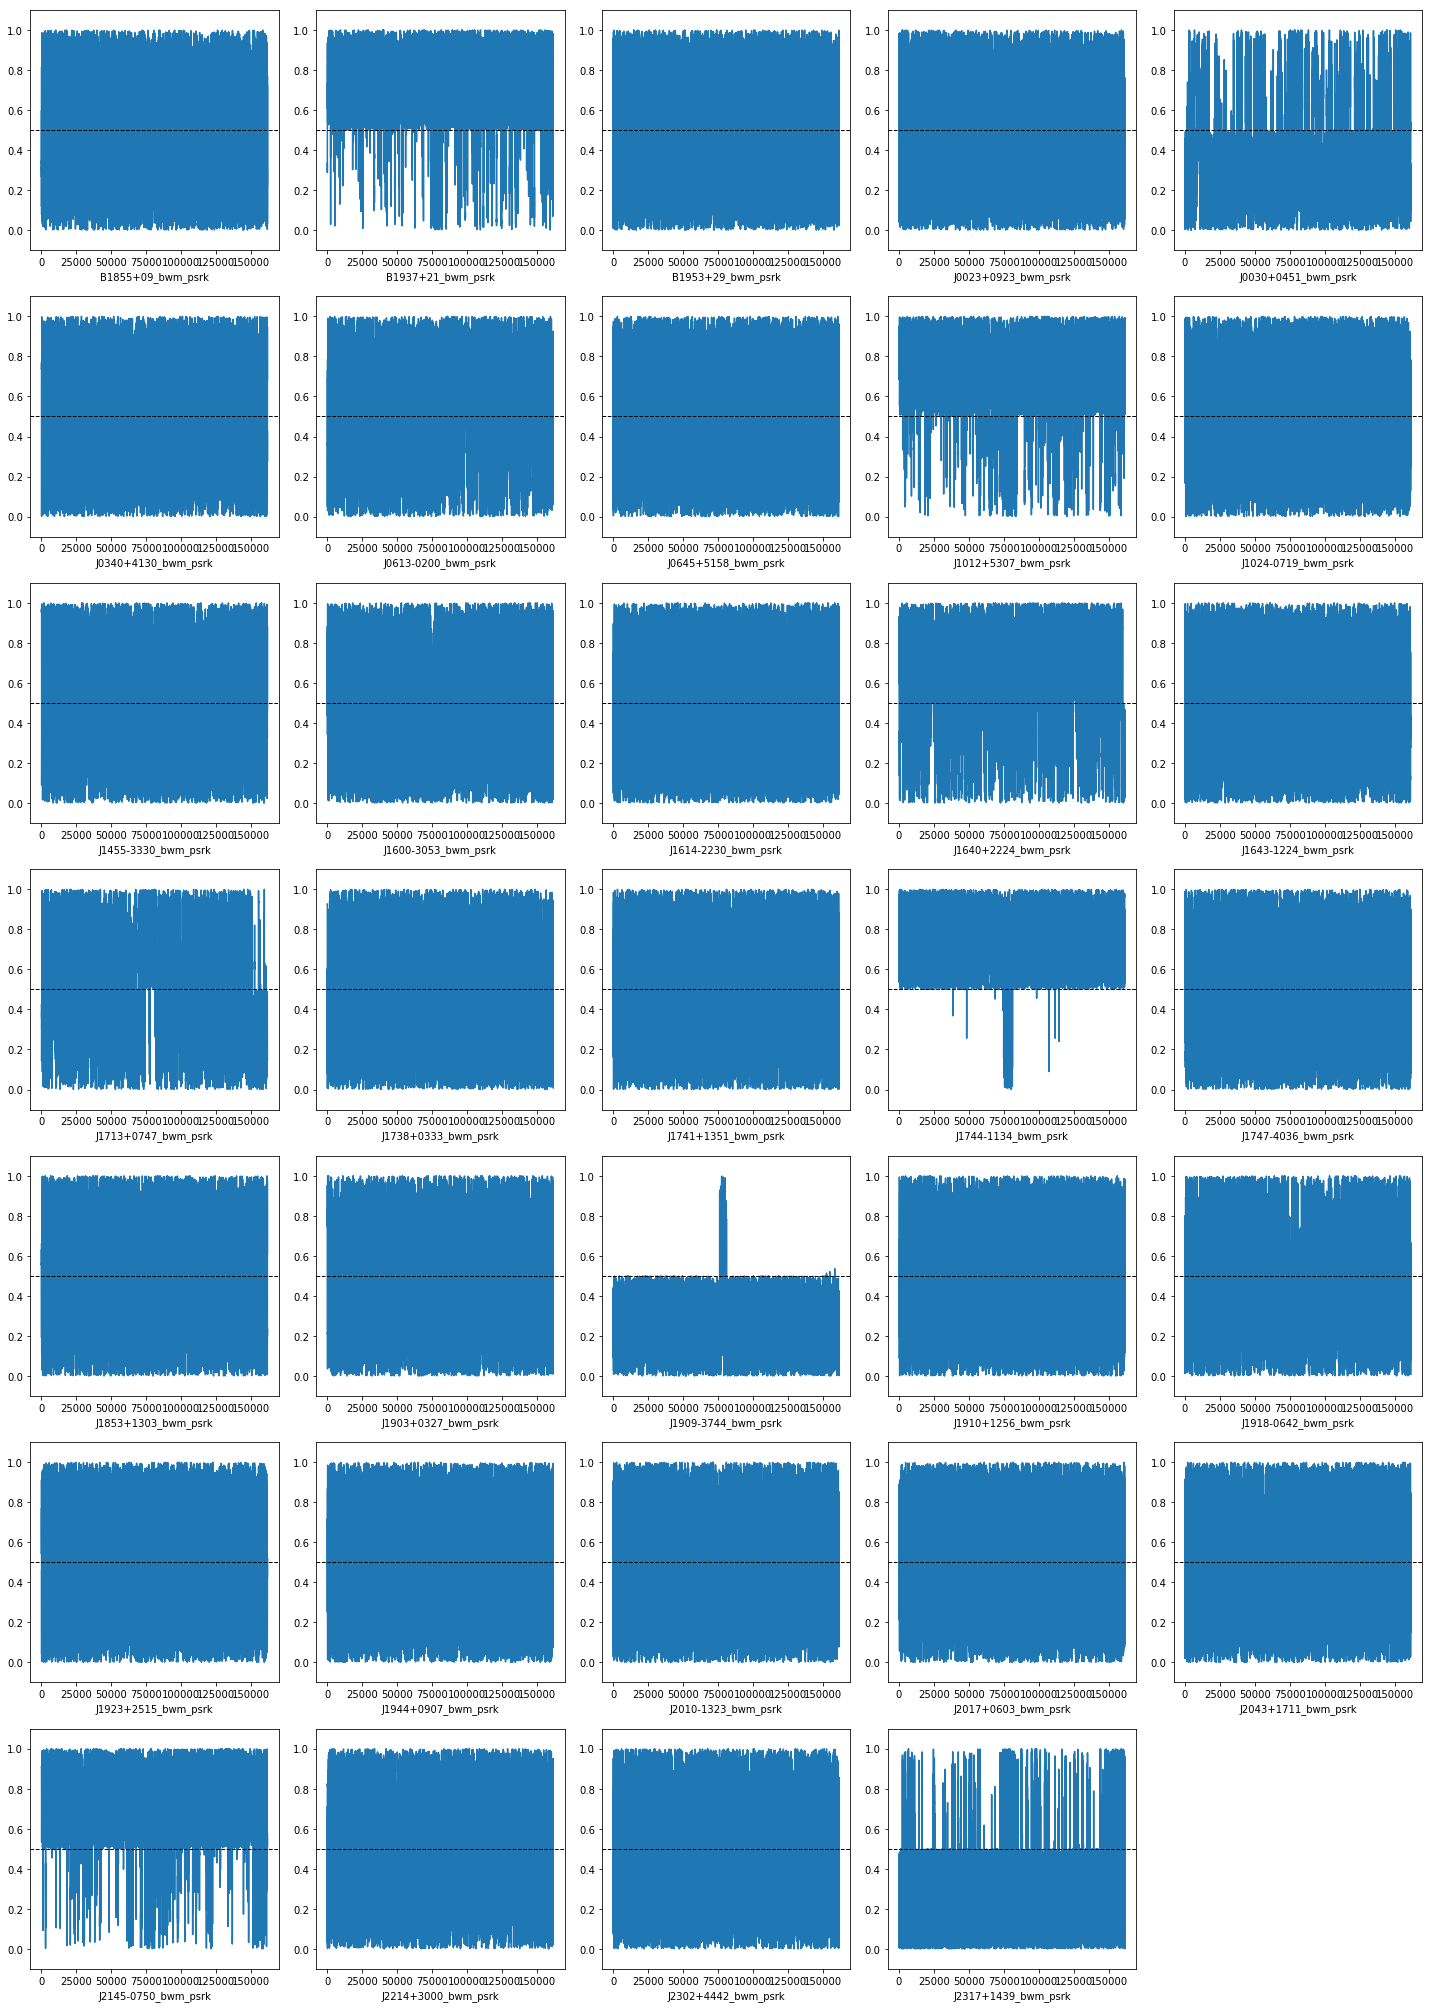

In [306]:
Ncols = 5
Nrows = len(par_k)//Ncols
if Nrows*Ncols < len(par_k):
    Nrows += 1
ax = []
fig = plt.figure(figsize=(20,4*Nrows))

for pp, par in enumerate(par_k):
    ax.append(fig.add_subplot(Nrows,Ncols,pp+1))
    ax[pp].plot(chain[:,idx_k[pp]])
    ax[pp].axhline(y=0.5, color='k', ls='--', lw=1)
    ax[pp].set_ylim([-0.1,1.1])
    ax[pp].set_xlabel(par)
plt.tight_layout()

In [307]:
Os = []
psrnames = []
for p, par in enumerate(par_k):
    on = sum(np.rint(chain[:,idx_k[p]]))/len(chain)
    off = 1 - on
    odds = on/off
    psrname = par.split('_')[0]
    psrnames.append(psrname)
    Os.append(odds)
    if psrname[0]=='B':
        psrname = '  '+psrname
    print("{:s} on frac = {:.2f}, Odds = {:.2f}".format(psrname, on, odds))
Os = np.array(Os)
psrnames = np.array(psrnames)
ii = np.argsort(Os)

  B1855+09 on frac = 0.47, Odds = 0.89
  B1937+21 on frac = 0.91, Odds = 9.64
  B1953+29 on frac = 0.50, Odds = 1.02
J0023+0923 on frac = 0.50, Odds = 1.02
J0030+0451 on frac = 0.24, Odds = 0.31
J0340+4130 on frac = 0.52, Odds = 1.07
J0613-0200 on frac = 0.58, Odds = 1.36
J0645+5158 on frac = 0.50, Odds = 1.00
J1012+5307 on frac = 0.88, Odds = 7.32
J1024-0719 on frac = 0.51, Odds = 1.06
J1455-3330 on frac = 0.51, Odds = 1.04
J1600-3053 on frac = 0.50, Odds = 1.00
J1614-2230 on frac = 0.50, Odds = 0.99
J1640+2224 on frac = 0.74, Odds = 2.88
J1643-1224 on frac = 0.46, Odds = 0.84
J1713+0747 on frac = 0.50, Odds = 1.01
J1738+0333 on frac = 0.50, Odds = 0.98
J1741+1351 on frac = 0.50, Odds = 1.02
J1744-1134 on frac = 0.97, Odds = 34.35
J1747-4036 on frac = 0.50, Odds = 0.99
J1853+1303 on frac = 0.51, Odds = 1.02
J1903+0327 on frac = 0.48, Odds = 0.93
J1909-3744 on frac = 0.02, Odds = 0.02
J1910+1256 on frac = 0.49, Odds = 0.97
J1918-0642 on frac = 0.46, Odds = 0.84
J1923+2515 on frac = 0.4

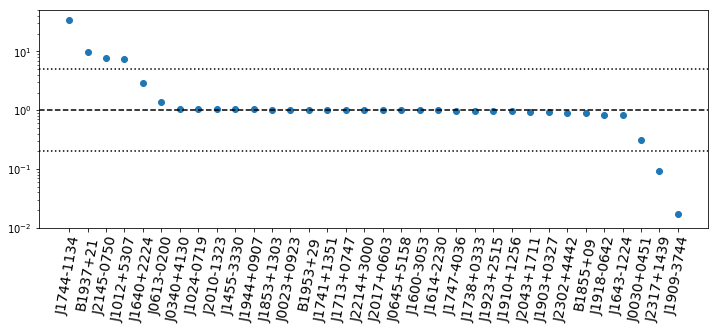

In [315]:
xs = np.arange(len(Os))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)

ax.plot(xs, Os[ii[::-1]], linestyle='none', marker='o')
ax.axhline(y=1, color='k', ls='--')
ax.axhline(y=5, color='k', ls=':')
ax.axhline(y=1/5, color='k', ls=':')
ax.set_xticks(xs)
ax.set_xticklabels(psrnames[ii[::-1]], rotation=80, fontsize=14)
ax.set_ylim([1/100,50])
ax.set_yscale('log')

In [292]:
sig_psrs = ['J0030+0451', 'J1909-3744', 'J2145-0750', 'J0613-0200', 'B1937+21', 'J2317+1439']

par_sig = []
idx_sig = []
for psr in sig_psrs:
    for par in params:
        if psr in par and "_psrk" in par:
            idx_sig.append(params.index(par))
            par_sig.append(par)

[u'J0030+0451_bwm_psrk', u'J1909-3744_bwm_psrk', u'J2145-0750_bwm_psrk', u'J0613-0200_bwm_psrk', u'B1937+21_bwm_psrk', u'J2317+1439_bwm_psrk']


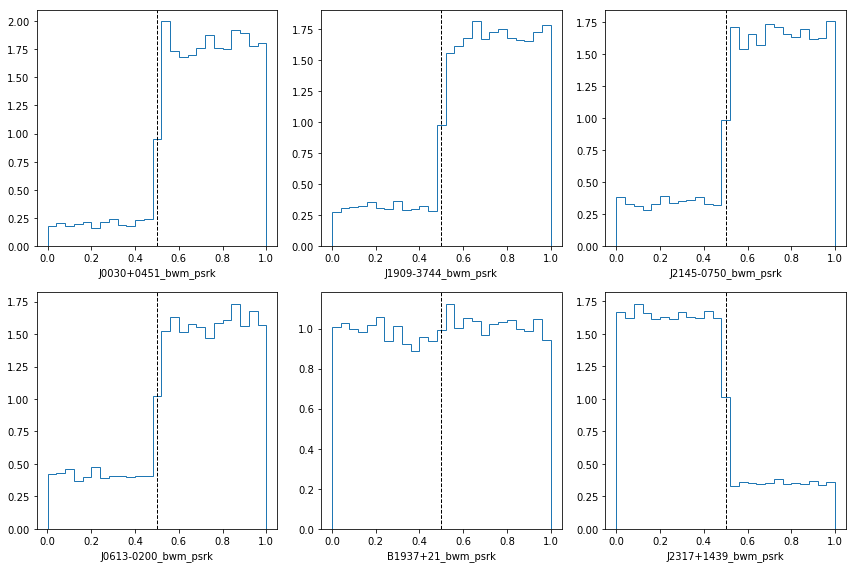

In [296]:
ax = []
fig = plt.figure(figsize=(12,8))

for pp, par in enumerate(par_sig):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].hist(chain[:,idx_sig[pp]], bins=25, normed=True, histtype='step') #, label='')
    ax[pp].axvline(x=0.5, color='k', ls='--', lw=1)
    ax[pp].set_xlabel(par)
    #ax[pp].set_yscale('log')
plt.tight_layout()